# Hackathon - The Ultimate Student Hunt

Analytics Vidhya hosted a student-only [hackathon](https://datahack.analyticsvidhya.com/contest/the-ultimate-student-hunt/#activity_id) over predicting the number of visitors to parks given a set amount of variables.  This was my first data competition, and proved to be a huge learning experience.

Here's a brief overview of the data from the contest rules listed on the website:

- **ID**: Unique ID
- **Park_ID**: Unique ID for Parks
- **Date**: Calendar Date
- **Direction_Of_Wind**: Direction of winds in degrees
- **Average_Breeze_Speed**: Daily average Breeze speed
- **Max_Breeze_Speed**: Daily maximum Breeze speed
- **Min_Breeze_Speed**: Daily minimum Breeze speed
- **Var1**: A continuous feature
- **Average_Atmospheric_Pressure**: Daily average atmospheric pressure
- **Max_Atmospheric_Pressure**: Daily maximum atmospheric pressure
- **Min_Atmospheric_Pressure**: Daily minimum atmospheric pressure
- **Min_Ambient_Pollution**: Daily minimum Ambient pollution
- **Max_Ambient_Pollution**: Daily maximum Ambient pollution
- **Average_Moisture_In_Park**: Daily average moisture
- **Max_Moisture_In_Park**: Daily maximum moisture
- **Min_Moisture_In_Park**: Daily minimum moisture
- **Location_Type**: Location Type (1/2/3/4)
- **Footfall**: The target variable, daily Footfall

## Summary

This problem involved predicting the number of visitors (footfall) to parks on a given day with given conditions, which ultimately makes it a time series problem.  Specifically, it provided ten years as a training set, and five years for the test set.  This notebook is an annotated version of my final submission which ranked 13th on the leaderboard.  On a side note, the hackathon was only open for nine days, so there is of course a lot of room for improvement in this notebook. 

My process for this hackathon was as follows:
1. **Initial Exploration**: All data projects should begin with an initial exploration to understand the data itself.  I initially used the [pandas profiling](https://github.com/JosPolfliet/pandas-profiling) package, but excluded it from my final submission since it generates a lengthy report.  I left both a quick df.describe() and df.head() to showcase summary statistics and an example of the data.
2. **Outliers**: I created boxplots to look for outliers visually.  This can be done mathematically when you are more familiar with the data (using methods such as interquartile ranges), but the distributions of the variables produced a significant amount of data points that would've been considered outliers with this methodology.
3. **Missing Values**: I first sorted the dataframe by date and park ID, then used the [msno package](https://github.com/ResidentMario/missingno) to visually examine missing values.  After seeing fairly regular trends of missing values, I plotted histograms of the missing values by park IDs to see if I could fill them by linearly interpolating.  After seeing that certain park IDs were completely missing some values, I built random forest models to impute them.  This is a brute-force method that is CPU intensive, but was a trade-off for the limited time frame. 
4. **Feature Engineering**: This was almost non-existant in this competition due to the anonymity of the data.  I used daily and weekly averages of the individual variables in both the end model and missing value imputation models.
5. **Model Building**: I initially started by creating three models using random forests, gradient boosted trees, and AdaBoost.  The gradient boosted trees model outperformed the other two, so I stuck with that and scrapped the other two.
6. **Hyperparameter Tuning**: This was my first time using gradient boosted trees, so I took a trial-and-error approach by adjusting various parameters and running them through cross validation to see how differently they performed.  I found that just adjusting the number of trees and max depth obtained the best results in this situation.
7. **Validation**: I used both a holdout cross-validation and k-folds (with 10 folds) to check for overfitting.  The hackathon also had a "solution checker" for your predicted values (specifically for the first two years of the test set - the final score of the competition was on the full five years of the test set, so it is very important to not overfit) that provided a score, which I used in combination with the cross validation results.

Here is the annotated code for my final submission:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import Imputer

# For exploratory data analysis
import missingno as msno  # Visualizes missing values

%matplotlib inline

In [2]:
df = pd.read_csv('crime.csv')  # Training set - ignore the name

df_test = pd.read_csv('Test_pyI9Owa.csv')  # Testing set

## Exploratory Data Analysis

In [3]:
df.describe()

,ID,Park_ID,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park,Location_Type,Footfall
count,1.145390e+05,114539.000000,110608.000000,110608.000000,110603.000000,110605.000000,106257.000000,74344.000000,74344.000000,74344.000000,82894.000000,82894.000000,114499.000000,114499.000000,114499.000000,114539.000000,114539.000000
mean,3.517595e+06,25.582596,179.587146,34.255340,51.704297,17.282553,18.802545,8331.545949,8356.053468,8305.692510,162.806138,306.555698,248.008970,283.917082,202.355331,2.630720,1204.217192
std,1.189083e+05,8.090592,85.362934,17.440065,22.068301,14.421844,38.269851,80.943971,76.032983,87.172258,90.869627,38.188020,28.898084,15.637930,46.365728,0.967435,248.385651
min,3.311712e+06,12.000000,1.000000,3.040000,7.600000,0.000000,0.000000,7982.000000,8037.000000,7890.000000,4.000000,8.000000,102.000000,141.000000,48.000000,1.000000,310.000000
25%,3.414820e+06,18.000000,111.000000,22.040000,38.000000,7.600000,0.000000,8283.000000,8311.000000,8252.000000,80.000000,288.000000,231.000000,279.000000,171.000000,2.000000,1026.000000
50%,3.517039e+06,26.000000,196.000000,30.400000,45.600000,15.200000,0.830000,8335.000000,8358.000000,8311.000000,180.000000,316.000000,252.000000,288.000000,207.000000,3.000000,1216.000000
75%,3.619624e+06,33.000000,239.000000,42.560000,60.800000,22.800000,21.580000,8382.000000,8406.000000,8362.000000,244.000000,336.000000,270.000000,294.000000,237.000000,3.000000,1402.000000
max,3.725639e+06,39.000000,360.000000,154.280000,212.800000,129.200000,1181.090000,8588.000000,8601.000000,8571.000000,348.000000,356.000000,300.000000,300.000000,300.000000,4.000000,1925.000000


In [4]:
df.head()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,Min_Atmospheric_Pressure,Min_Ambient_Pollution,Max_Ambient_Pollution,Average_Moisture_In_Park,Max_Moisture_In_Park,Min_Moisture_In_Park,Location_Type,Footfall
0,3311712,12,01-09-1990,194.0,37.24,60.8,15.2,92.1300,8225.0,8259.0,8211.0,92.0,304.0,255.0,288.0,222.0,3,1406
1,3311812,12,02-09-1990,285.0,32.68,60.8,7.6,14.1100,8232.0,8280.0,8205.0,172.0,332.0,252.0,297.0,204.0,3,1409
2,3311912,12,03-09-1990,319.0,43.32,60.8,15.2,35.6900,8321.0,8355.0,8283.0,236.0,292.0,219.0,279.0,165.0,3,1386
3,3312012,12,04-09-1990,297.0,25.84,38.0,7.6,0.0249,8379.0,8396.0,8358.0,272.0,324.0,225.0,261.0,192.0,3,1365
4,3312112,12,05-09-1990,207.0,28.88,45.6,7.6,0.8300,8372.0,8393.0,8335.0,236.0,332.0,234.0,273.0,183.0,3,1413


### Outliers

We'll do our outlier detection visually with box plots.  Rather than determining outliers mathematically (such as using the interquartile range), we'll simply look for any points that aren't contiguous.

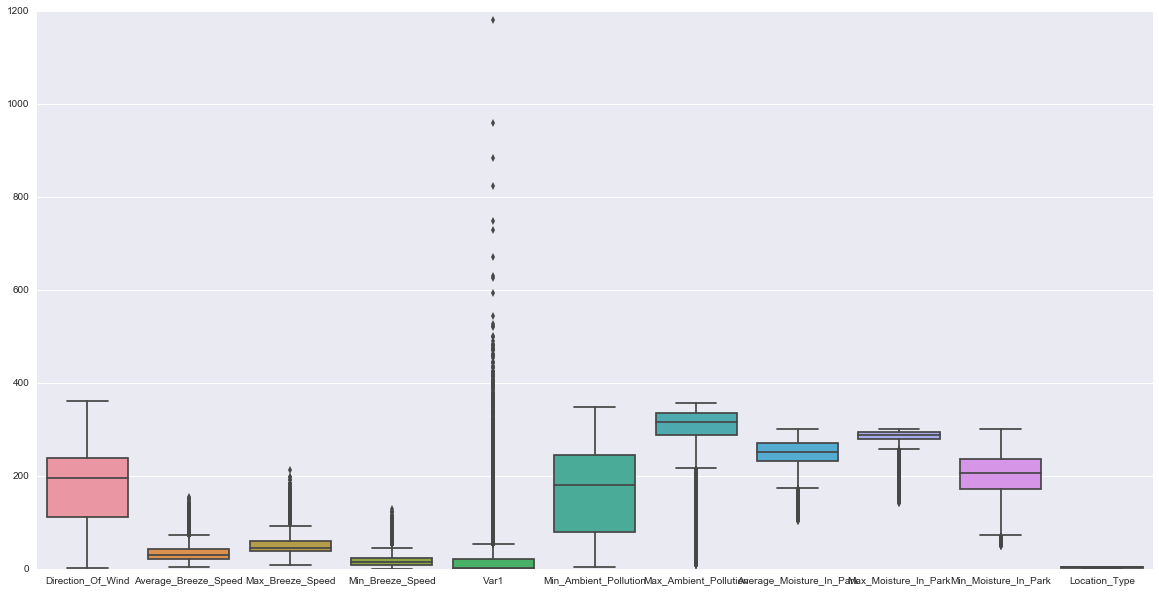

In [5]:
df_box = df.drop(['ID', 'Park_ID', 'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure'
                  , 'Min_Atmospheric_Pressure', 'Footfall', 'Date'], axis = 1)
plt.figure(figsize = (20,10))
sns.boxplot(data=df_box)

Var1 seems to potentially have outliers, but since it is undefined, it is difficult to determine if these are anomalies or noisy/incorrect data.  We'll leave them for now.

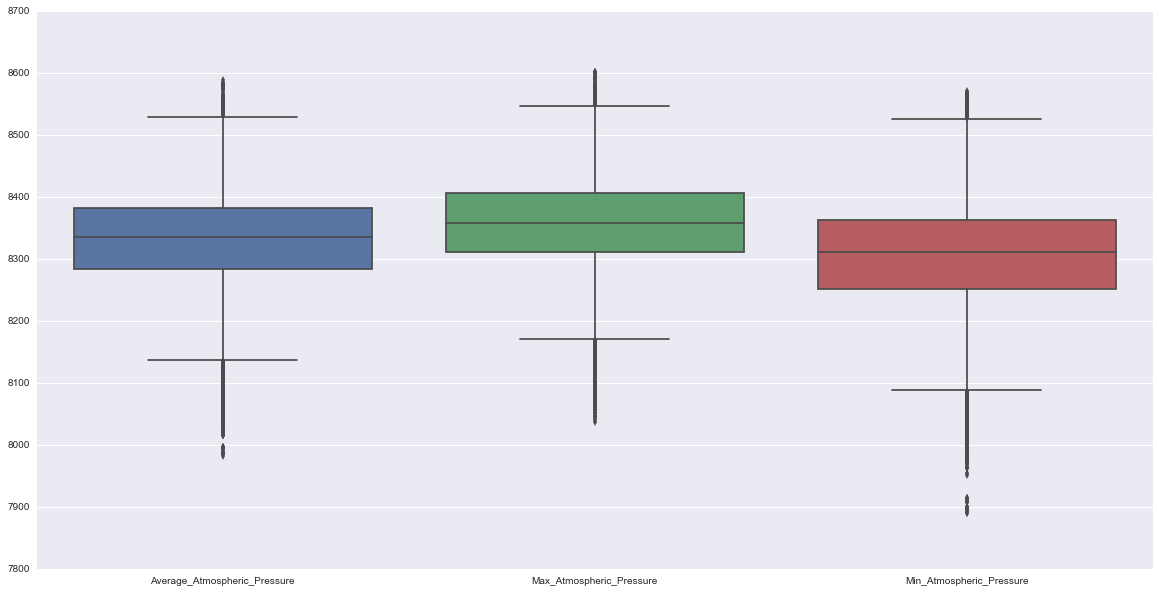

In [6]:
df_box = df[['Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure'
                  , 'Min_Atmospheric_Pressure']]
plt.figure(figsize = (20,10))
sns.boxplot(data=df_box)

Max atmospheric pressure (and by result, average atmospheric pressure) have a few non-contiguous values, but they don't seem egregious enough to deal with for the time being.

In [7]:
# Converting date field to datetime and extracting date components
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Week'] = pd.DatetimeIndex(df['Date']).week
df['WeekDay'] = pd.DatetimeIndex(df['Date']).dayofweek


# Repeating for the test set
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test['Year'] = pd.DatetimeIndex(df_test['Date']).year
df_test['Month'] = pd.DatetimeIndex(df_test['Date']).month
df_test['Day'] = pd.DatetimeIndex(df_test['Date']).day
df_test['Week'] = pd.DatetimeIndex(df_test['Date']).week
df_test['WeekDay'] = pd.DatetimeIndex(df_test['Date']).dayofweek


# Lastly, combining to use for building models to predict missing predictors 
df_full = df.append(df_test)

### Missing Values

Since this is ultimately a time series problem, we'll begin with sorting the values.  Then, I'm going to use a [useful package](https://github.com/ResidentMario/missingno) for visualizing missing values.

In [8]:
# Sorting by date and park
df = df.sort_values(['Date', 'Park_ID'], ascending=[1, 1])
df_full = df_full.sort_values(['Date', 'Park_ID'], ascending=[1, 1])

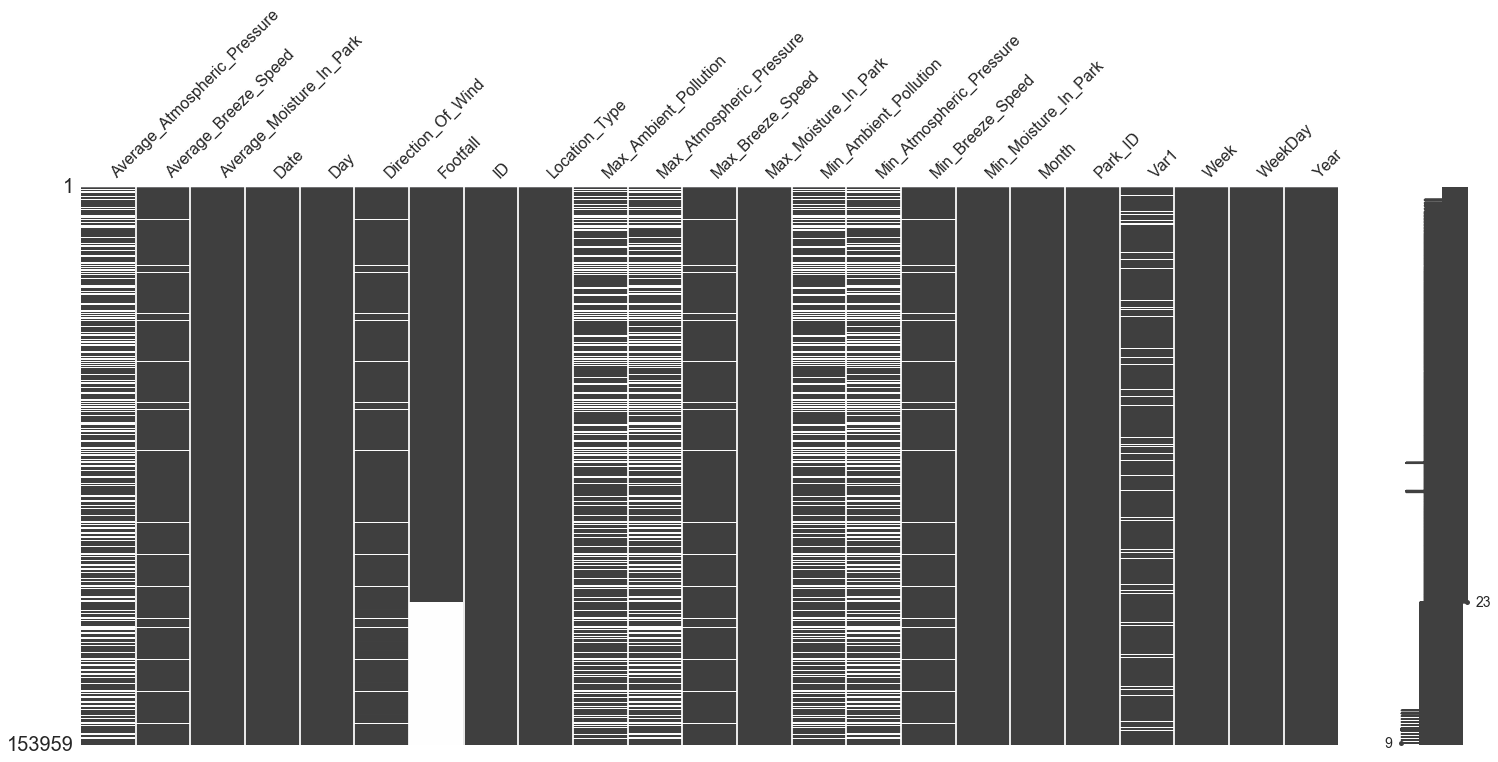

In [9]:
# Visualizing missing values
msno.matrix(df_full)

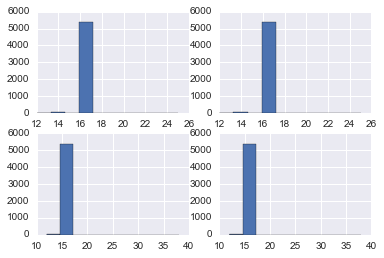

In [10]:
# Checking which Park IDs missing values occur in
plt.subplot(221)
df_full[df_full['Direction_Of_Wind'].isnull() == True]['Park_ID'].hist()
plt.subplot(222)
df_full[df_full['Average_Breeze_Speed'].isnull() == True]['Park_ID'].hist()
plt.subplot(223)
df_full[df_full['Max_Breeze_Speed'].isnull() == True]['Park_ID'].hist()
plt.subplot(224)
df_full[df_full['Min_Breeze_Speed'].isnull() == True]['Park_ID'].hist()

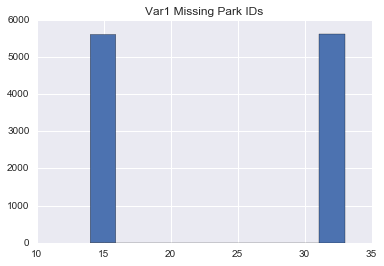

In [11]:
df_full[df_full['Var1'].isnull() == True]['Park_ID'].hist()
plt.title('Var1 Missing Park IDs')

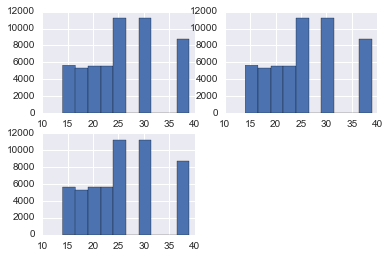

In [12]:
plt.subplot(221)
df_full[df_full['Average_Atmospheric_Pressure'].isnull() == True]['Park_ID'].hist()
plt.subplot(222)
df_full[df_full['Max_Atmospheric_Pressure'].isnull() == True]['Park_ID'].hist()
plt.subplot(223)
df_full[df_full['Min_Atmospheric_Pressure'].isnull() == True]['Park_ID'].hist()

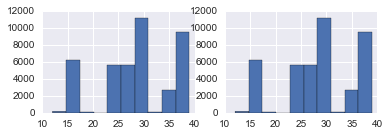

In [13]:
plt.subplot(221)
df_full[df_full['Max_Ambient_Pollution'].isnull() == True]['Park_ID'].hist()
plt.subplot(222)
df_full[df_full['Min_Ambient_Pollution'].isnull() == True]['Park_ID'].hist()

We can see here that most missing values are re-occurring in the same parks.  This means we can't interpolate our missing values, and filling with the mean/median/mode is to over-generalized, so we should build models to predict our missing values.

Msno has a heatmap that shows the co-occurrance of missing values, which will be helpful in determining how to construct our models.

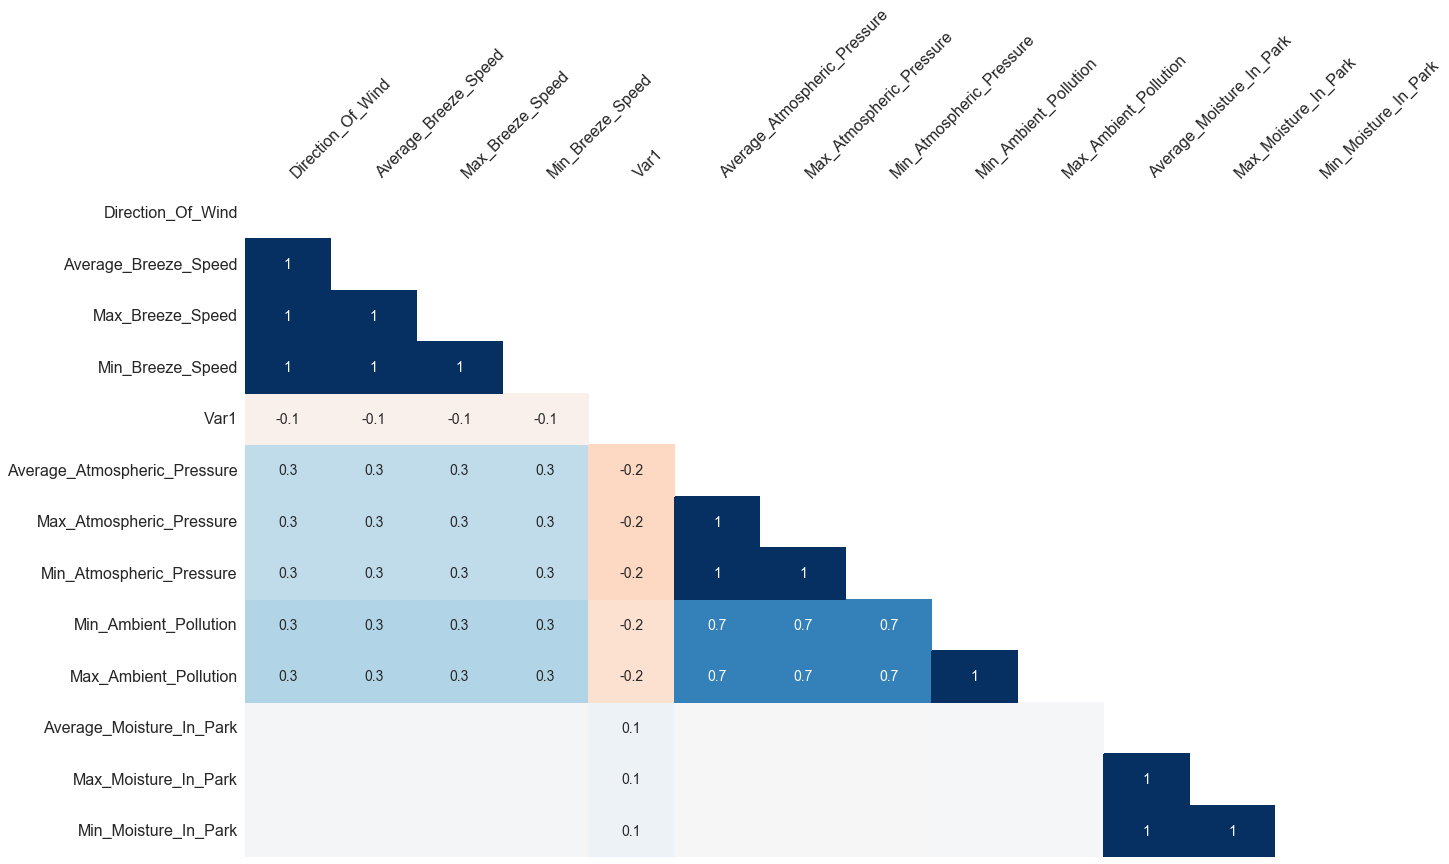

In [14]:
# Co-occurrence of missing values
msno.heatmap(df)

## Feature Engineering

#### Daily & Weekly Averages
Before building models to predict the missing values, we'll begin with calculating daily and weekly averages across all parks to assist wth our predictions.

There is a lot of repetition here due to re-running the same code for both the training and testing set.

*Training Set*

In [15]:
# Gathering the daily averages of predictors

# Wind
avg_daily_breeze = df['Average_Breeze_Speed'].groupby(df['Date']).mean().to_frame().reset_index()  # Group by day
avg_daily_breeze.columns = ['Date', 'Avg_Daily_Breeze']  # Renaming the columns for the join
df = df.merge(avg_daily_breeze, how = 'left')  # Joining onto the original dataframe

max_daily_breeze = df['Max_Breeze_Speed'].groupby(df['Date']).mean().to_frame().reset_index()
max_daily_breeze.columns = ['Date', 'Max_Daily_Breeze']
df = df.merge(max_daily_breeze, how = 'left')

min_daily_breeze = df['Min_Breeze_Speed'].groupby(df['Date']).mean().to_frame().reset_index()
min_daily_breeze.columns = ['Date', 'Min_Daily_Breeze']
df = df.merge(min_daily_breeze, how = 'left')


# Var1
var1_daily = df['Var1'].groupby(df['Date']).mean().to_frame().reset_index()
var1_daily.columns = ['Date', 'Var1_Daily']
df = df.merge(var1_daily, how = 'left')


# Atmosphere & Pollution
avg_daily_atmo = df['Average_Atmospheric_Pressure'].groupby(df['Date']).mean().to_frame().reset_index()
avg_daily_atmo.columns = ['Date', 'Avg_Daily_Atmosphere']
df = df.merge(avg_daily_atmo, how = 'left')

max_daily_atmo = df['Max_Atmospheric_Pressure'].groupby(df['Date']).mean().to_frame().reset_index()
max_daily_atmo.columns = ['Date', 'Max_Daily_Atmosphere']
df = df.merge(max_daily_atmo, how = 'left')

min_daily_atmo = df['Min_Atmospheric_Pressure'].groupby(df['Date']).mean().to_frame().reset_index()
min_daily_atmo.columns = ['Date', 'Min_Daily_Atmosphere']
df = df.merge(min_daily_atmo, how = 'left')

max_daily_pollution = df['Max_Ambient_Pollution'].groupby(df['Date']).mean().to_frame().reset_index()
max_daily_pollution.columns = ['Date', 'Max_Daily_Pollution']
df = df.merge(max_daily_pollution, how = 'left')

min_daily_pollution = df['Min_Ambient_Pollution'].groupby(df['Date']).mean().to_frame().reset_index()
min_daily_pollution.columns = ['Date', 'Min_Daily_Pollution']
df = df.merge(min_daily_pollution, how = 'left')


# Moisture
avg_daily_moisture = df['Average_Moisture_In_Park'].groupby(df['Date']).mean().to_frame().reset_index()
avg_daily_moisture.columns = ['Date', 'Avg_Daily_moisture']
df = df.merge(avg_daily_moisture, how = 'left')

max_daily_moisture = df['Max_Moisture_In_Park'].groupby(df['Date']).mean().to_frame().reset_index()
max_daily_moisture.columns = ['Date', 'Max_Daily_moisture']
df = df.merge(max_daily_moisture, how = 'left')

min_daily_moisture = df['Min_Moisture_In_Park'].groupby(df['Date']).mean().to_frame().reset_index()
min_daily_moisture.columns = ['Date', 'Min_Daily_moisture']
df = df.merge(min_daily_moisture, how = 'left')

In [16]:
# Repeating with weekly averages of predictors

# Wind
avg_weekly_breeze = df['Average_Breeze_Speed'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
avg_weekly_breeze.columns = ['Year', 'Week', 'Avg_Weekly_Breeze']
df = df.merge(avg_weekly_breeze, how = 'left')

max_weekly_breeze = df['Max_Breeze_Speed'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
max_weekly_breeze.columns = ['Year', 'Week', 'Max_Weekly_Breeze']
df = df.merge(max_weekly_breeze, how = 'left')

min_weekly_breeze = df['Min_Breeze_Speed'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
min_weekly_breeze.columns = ['Year', 'Week', 'Min_Weekly_Breeze']
df = df.merge(min_weekly_breeze, how = 'left')


# Var 1
var1_weekly = df['Var1'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
var1_weekly.columns = ['Year', 'Week', 'Var1_Weekly']
df = df.merge(var1_weekly, how = 'left')


# Atmosphere & Pollution
avg_weekly_atmo = df['Average_Atmospheric_Pressure'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
avg_weekly_atmo.columns = ['Year', 'Week', 'Avg_Weekly_Atmosphere']
df = df.merge(avg_weekly_atmo, how = 'left')

max_weekly_atmo = df['Max_Atmospheric_Pressure'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
max_weekly_atmo.columns = ['Year', 'Week', 'Max_Weekly_Atmosphere']
df = df.merge(max_weekly_atmo, how = 'left')

min_weekly_atmo = df['Min_Atmospheric_Pressure'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
min_weekly_atmo.columns = ['Year', 'Week', 'Min_Weekly_Atmosphere']
df = df.merge(min_weekly_atmo, how = 'left')

max_weekly_pollution = df['Max_Ambient_Pollution'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
max_weekly_pollution.columns = ['Year', 'Week', 'Max_Weekly_Pollution']
df = df.merge(max_weekly_pollution, how = 'left')

min_weekly_pollution = df['Min_Ambient_Pollution'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
min_weekly_pollution.columns = ['Year', 'Week', 'Min_Weekly_Pollution']
df = df.merge(min_weekly_pollution, how = 'left')


# Moisture
avg_weekly_moisture = df['Average_Moisture_In_Park'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
avg_weekly_moisture.columns = ['Year', 'Week', 'Avg_Weekly_Moisture']
df = df.merge(avg_weekly_moisture, how = 'left')

max_weekly_moisture = df['Max_Moisture_In_Park'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
max_weekly_moisture.columns = ['Year', 'Week', 'Max_Weekly_Moisture']
df = df.merge(max_weekly_moisture, how = 'left')

min_weekly_moisture = df['Min_Moisture_In_Park'].groupby((df['Year'], df['Week'])).mean().to_frame().reset_index()
min_weekly_moisture.columns = ['Year', 'Week', 'Min_Weekly_Moisture']
df = df.merge(min_weekly_moisture, how = 'left')

*Testing Set*

In [17]:
# Gathering the daily averages of predictors

# Wind
avg_daily_breeze = df_test['Average_Breeze_Speed'].groupby(df_test['Date']).mean().to_frame().reset_index()
avg_daily_breeze.columns = ['Date', 'Avg_Daily_Breeze']
df_test = df_test.merge(avg_daily_breeze, how = 'left')

max_daily_breeze = df_test['Max_Breeze_Speed'].groupby(df_test['Date']).mean().to_frame().reset_index()
max_daily_breeze.columns = ['Date', 'Max_Daily_Breeze']
df_test = df_test.merge(max_daily_breeze, how = 'left')

min_daily_breeze = df_test['Min_Breeze_Speed'].groupby(df_test['Date']).mean().to_frame().reset_index()
min_daily_breeze.columns = ['Date', 'Min_Daily_Breeze']
df_test = df_test.merge(min_daily_breeze, how = 'left')


# Var1
var1_daily = df_test['Var1'].groupby(df_test['Date']).mean().to_frame().reset_index()
var1_daily.columns = ['Date', 'Var1_Daily']
df_test = df_test.merge(var1_daily, how = 'left')


# Atmosphere & Pollution
avg_daily_atmo = df_test['Average_Atmospheric_Pressure'].groupby(df_test['Date']).mean().to_frame().reset_index()
avg_daily_atmo.columns = ['Date', 'Avg_Daily_Atmosphere']
df_test = df_test.merge(avg_daily_atmo, how = 'left')
                        
max_daily_atmo = df_test['Max_Atmospheric_Pressure'].groupby(df_test['Date']).mean().to_frame().reset_index()
max_daily_atmo.columns = ['Date', 'Max_Daily_Atmosphere']
df_test = df_test.merge(max_daily_atmo, how = 'left')
                        
min_daily_atmo = df_test['Min_Atmospheric_Pressure'].groupby(df_test['Date']).mean().to_frame().reset_index()
min_daily_atmo.columns = ['Date', 'Min_Daily_Atmosphere']
df_test = df_test.merge(min_daily_atmo, how = 'left')
                        
max_daily_pollution = df_test['Max_Ambient_Pollution'].groupby(df_test['Date']).mean().to_frame().reset_index()
max_daily_pollution.columns = ['Date', 'Max_Daily_Pollution']
df_test = df_test.merge(max_daily_pollution, how = 'left')
                        
min_daily_pollution = df_test['Min_Ambient_Pollution'].groupby(df_test['Date']).mean().to_frame().reset_index()
min_daily_pollution.columns = ['Date', 'Min_Daily_Pollution']
df_test = df_test.merge(min_daily_pollution, how = 'left')


# Moisture
avg_daily_moisture = df_test['Average_Moisture_In_Park'].groupby(df_test['Date']).mean().to_frame().reset_index()
avg_daily_moisture.columns = ['Date', 'Avg_Daily_moisture']
df_test = df_test.merge(avg_daily_moisture, how = 'left')
                        
max_daily_moisture = df_test['Max_Moisture_In_Park'].groupby(df_test['Date']).mean().to_frame().reset_index()
max_daily_moisture.columns = ['Date', 'Max_Daily_moisture']
df_test = df_test.merge(max_daily_moisture, how = 'left')
                        
min_daily_moisture = df_test['Min_Moisture_In_Park'].groupby(df_test['Date']).mean().to_frame().reset_index()
min_daily_moisture.columns = ['Date', 'Min_Daily_moisture']
df_test = df_test.merge(min_daily_moisture, how = 'left')

In [18]:
# Repeating with weekly averages of predictors

# Wind
avg_weekly_breeze = df_test['Average_Breeze_Speed'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
avg_weekly_breeze.columns = ['Year', 'Week', 'Avg_Weekly_Breeze']
df_test = df_test.merge(avg_weekly_breeze, how = 'left')

max_weekly_breeze = df_test['Max_Breeze_Speed'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
max_weekly_breeze.columns = ['Year', 'Week', 'Max_Weekly_Breeze']
df_test = df_test.merge(max_weekly_breeze, how = 'left')

min_weekly_breeze = df_test['Min_Breeze_Speed'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
min_weekly_breeze.columns = ['Year', 'Week', 'Min_Weekly_Breeze']
df_test = df_test.merge(min_weekly_breeze, how = 'left')


# Var 1
var1_weekly = df_test['Var1'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
var1_weekly.columns = ['Year', 'Week', 'Var1_Weekly']
df_test = df_test.merge(var1_weekly, how = 'left')


# Atmosphere & Pollution
avg_weekly_atmo = df_test['Average_Atmospheric_Pressure'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
avg_weekly_atmo.columns = ['Year', 'Week', 'Avg_Weekly_Atmosphere']
df_test = df_test.merge(avg_weekly_atmo, how = 'left')

max_weekly_atmo = df_test['Max_Atmospheric_Pressure'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
max_weekly_atmo.columns = ['Year', 'Week', 'Max_Weekly_Atmosphere']
df_test = df_test.merge(max_weekly_atmo, how = 'left')

min_weekly_atmo = df_test['Min_Atmospheric_Pressure'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
min_weekly_atmo.columns = ['Year', 'Week', 'Min_Weekly_Atmosphere']
df_test = df_test.merge(min_weekly_atmo, how = 'left')

max_weekly_pollution = df_test['Max_Ambient_Pollution'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
max_weekly_pollution.columns = ['Year', 'Week', 'Max_Weekly_Pollution']
df_test = df_test.merge(max_weekly_pollution, how = 'left')

min_weekly_pollution = df_test['Min_Ambient_Pollution'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
min_weekly_pollution.columns = ['Year', 'Week', 'Min_Weekly_Pollution']
df_test = df_test.merge(min_weekly_pollution, how = 'left')


# Moisture
avg_weekly_moisture = df_test['Average_Moisture_In_Park'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
avg_weekly_moisture.columns = ['Year', 'Week', 'Avg_Weekly_Moisture']
df_test = df_test.merge(avg_weekly_moisture, how = 'left')

max_weekly_moisture = df_test['Max_Moisture_In_Park'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
max_weekly_moisture.columns = ['Year', 'Week', 'Max_Weekly_Moisture']
df_test = df_test.merge(max_weekly_moisture, how = 'left')

min_weekly_moisture = df_test['Min_Moisture_In_Park'].groupby((df_test['Year'], df_test['Week'])).mean().to_frame().reset_index()
min_weekly_moisture.columns = ['Year', 'Week', 'Min_Weekly_Moisture']
df_test = df_test.merge(min_weekly_moisture, how = 'left')

In [19]:
df_full = df.append(df_test)

## Handling Missing Values

- Using random forests for all missing value prediction for imputation
- For values with missing average, minimum, and maximum values, will first predict the average, then use that in predicting the minimum, then use both in predicting the maximum.

This section is relatively lengthy, and I used alot of copying/pasting.  There are better ways to handle this for something that would be used for production, but it got the job done for this application.

#### Average Atmospheric Pressure

In [20]:
X = df_full[df_full['Average_Atmospheric_Pressure'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year', 'Average_Atmospheric_Pressure'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(X)

y = df_full['Average_Atmospheric_Pressure'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_avg_atmosphere = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_avg_atmosphere.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [21]:
np.mean(cross_val_score(rfr_avg_atmosphere, X_test, y_test))

0.99347389326468905

In [22]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_avg_atmosphere = df[df['Average_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year', 'Average_Atmospheric_Pressure'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_avg_atmosphere = imp.fit_transform(X_avg_atmosphere)

avg_atmosphere_prediction = rfr_avg_atmosphere.predict(X_avg_atmosphere)
avg_atmosphere_prediction = pd.DataFrame({'ID':df.ix[(df['Average_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'avg_atmo_predict':avg_atmosphere_prediction})

df = df.merge(avg_atmosphere_prediction, how = 'left', on = 'ID')

df.Average_Atmospheric_Pressure.fillna(df.avg_atmo_predict, inplace=True)
del df['avg_atmo_predict']

In [23]:
# Predicting the missing values and filling them in the dataframe
# Test data
X_avg_atmosphere = df_test[df_test['Average_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Date', 'Average_Atmospheric_Pressure', 'Year'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_avg_atmosphere = imp.fit_transform(X_avg_atmosphere)

avg_atmosphere_prediction = rfr_avg_atmosphere.predict(X_avg_atmosphere)
avg_atmosphere_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Average_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'avg_atmo_predict':avg_atmosphere_prediction})

df_test = df_test.merge(avg_atmosphere_prediction, how = 'left', on = 'ID')

df_test.Average_Atmospheric_Pressure.fillna(df_test.avg_atmo_predict, inplace=True)
del df_test['avg_atmo_predict']

#### Max Atmospheric Pressure

In [24]:
X = df_full[df_full['Max_Atmospheric_Pressure'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Max_Atmospheric_Pressure'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_max_atmosphere = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_max_atmosphere.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [25]:
np.mean(cross_val_score(rfr_max_atmosphere, X_test, y_test))

0.9954164885643183

In [26]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_max_atmosphere = df[df['Max_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_max_atmosphere = imp.fit_transform(X_max_atmosphere)

max_atmosphere_prediction = rfr_max_atmosphere.predict(X_max_atmosphere)
max_atmosphere_prediction = pd.DataFrame({'ID':df.ix[(df['Max_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'max_atmo_predict':max_atmosphere_prediction})

df = df.merge(max_atmosphere_prediction, how = 'left', on = 'ID')

df.Max_Atmospheric_Pressure.fillna(df.max_atmo_predict, inplace=True)
del df['max_atmo_predict']

In [27]:
# Predicting the missing values and filling them in the dataframe
# Test data
X_max_atmosphere = df_test[df_test['Max_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              ,'Max_Atmospheric_Pressure'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_max_atmosphere = imp.fit_transform(X_max_atmosphere)

max_atmosphere_prediction = rfr_max_atmosphere.predict(X_max_atmosphere)
max_atmosphere_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Max_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'max_atmo_predict':max_atmosphere_prediction})

df_test = df_test.merge(max_atmosphere_prediction, how = 'left', on = 'ID')

df_test.Max_Atmospheric_Pressure.fillna(df_test.max_atmo_predict, inplace=True)
del df_test['max_atmo_predict']

#### Min Atmospheric Pressure

In [28]:
X = df_full[df_full['Min_Atmospheric_Pressure'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Max_Ambient_Pollution'
                                                              ,'Min_Ambient_Pollution'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Min_Atmospheric_Pressure'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_min_atmosphere = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_min_atmosphere.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
np.mean(cross_val_score(rfr_min_atmosphere, X_test, y_test))

0.99499363701433363

In [30]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_min_atmosphere = df[df['Min_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_min_atmosphere = imp.fit_transform(X_min_atmosphere)

min_atmosphere_prediction = rfr_min_atmosphere.predict(X_min_atmosphere)
min_atmosphere_prediction = pd.DataFrame({'ID':df.ix[(df['Min_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'min_atmo_predict':min_atmosphere_prediction})

df = df.merge(min_atmosphere_prediction, how = 'left', on = 'ID')

df.Min_Atmospheric_Pressure.fillna(df.min_atmo_predict, inplace=True)
del df['min_atmo_predict']

In [31]:
# Predicting the missing values and filling them in the dataframe
# Test data
X_min_atmosphere = df_test[df_test['Min_Atmospheric_Pressure'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              ,'Min_Atmospheric_Pressure'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_min_atmosphere = imp.fit_transform(X_min_atmosphere)

min_atmosphere_prediction = rfr_min_atmosphere.predict(X_min_atmosphere)
min_atmosphere_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Min_Atmospheric_Pressure'].isnull() == True)]['ID']
                                          ,'min_atmo_predict':min_atmosphere_prediction})

df_test = df_test.merge(min_atmosphere_prediction, how = 'left', on = 'ID')

df_test.Min_Atmospheric_Pressure.fillna(df_test.min_atmo_predict, inplace=True)
del df_test['min_atmo_predict']

#### Max Ambient Pollution

In [32]:
X = df_full[df_full['Max_Ambient_Pollution'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Max_Ambient_Pollution'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_max_pollution = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_max_pollution.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [33]:
np.mean(cross_val_score(rfr_max_pollution, X_test, y_test))

0.80003476426720599

In [34]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_max_pollution = df[df['Max_Ambient_Pollution'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_max_pollution = imp.fit_transform(X_max_pollution)

max_pollution_prediction = rfr_max_pollution.predict(X_max_pollution)
max_pollution_prediction = pd.DataFrame({'ID':df.ix[(df['Max_Ambient_Pollution'].isnull() == True)]['ID']
                                          ,'max_pollution_predict':max_pollution_prediction})

df = df.merge(max_pollution_prediction, how = 'left', on = 'ID')

df.Max_Ambient_Pollution.fillna(df.max_pollution_predict, inplace=True)
del df['max_pollution_predict']

In [35]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_max_pollution = df_test[df_test['Max_Ambient_Pollution'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'
                                                              ,'Max_Ambient_Pollution'], axis = 1)

X_max_pollution = imp.fit_transform(X_max_pollution)

max_pollution_prediction = rfr_max_pollution.predict(X_max_pollution)
max_pollution_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Max_Ambient_Pollution'].isnull() == True)]['ID']
                                          ,'max_pollution_predict':max_pollution_prediction})

df_test = df_test.merge(max_pollution_prediction, how = 'left', on = 'ID')

df_test.Max_Ambient_Pollution.fillna(df_test.max_pollution_predict, inplace=True)
del df_test['max_pollution_predict']

#### Min Ambient Pollution

In [36]:
X = df_full[df_full['Min_Ambient_Pollution'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Min_Ambient_Pollution'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_min_pollution = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_min_pollution.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
np.mean(cross_val_score(rfr_min_pollution, X_test, y_test))

0.75850550015000273

In [38]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_min_pollution = df[df['Min_Ambient_Pollution'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'], axis = 1)

X_min_pollution = imp.fit_transform(X_min_pollution)

min_pollution_prediction = rfr_min_pollution.predict(X_min_pollution)
min_pollution_prediction = pd.DataFrame({'ID':df.ix[(df['Min_Ambient_Pollution'].isnull() == True)]['ID']
                                          ,'min_pollution_predict':min_pollution_prediction})

df = df.merge(min_pollution_prediction, how = 'left', on = 'ID')

df.Min_Ambient_Pollution.fillna(df.min_pollution_predict, inplace=True)
del df['min_pollution_predict']

In [39]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_min_pollution = df_test[df_test['Min_Ambient_Pollution'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              ,'Min_Ambient_Pollution'], axis = 1)

X_min_pollution = imp.fit_transform(X_min_pollution)

min_pollution_prediction = rfr_min_pollution.predict(X_min_pollution)
min_pollution_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Min_Ambient_Pollution'].isnull() == True)]['ID']
                                          ,'min_pollution_predict':min_pollution_prediction})

df_test = df_test.merge(min_pollution_prediction, how = 'left', on = 'ID')

df_test.Min_Ambient_Pollution.fillna(df_test.min_pollution_predict, inplace=True)
del df_test['min_pollution_predict']

#### Average Breeze Speed

In [40]:
X = df_full[df_full['Average_Breeze_Speed'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Average_Breeze_Speed'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Average_Breeze_Speed'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_avg_breeze = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_avg_breeze.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [41]:
np.mean(cross_val_score(rfr_avg_breeze, X_test, y_test))

0.91409857146873208

In [42]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_avg_breeze = df[df['Average_Breeze_Speed'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              ,'Average_Breeze_Speed'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_avg_breeze = imp.fit_transform(X_avg_breeze)

avg_breeze_prediction = rfr_avg_breeze.predict(X_avg_breeze)
avg_breeze_prediction = pd.DataFrame({'ID':df.ix[(df['Average_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'avg_breeze_predict':avg_breeze_prediction})

df = df.merge(avg_breeze_prediction, how = 'left', on = 'ID')

df.Average_Breeze_Speed.fillna(df.avg_breeze_predict, inplace=True)
del df['avg_breeze_predict']

In [43]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_avg_breeze = df_test[df_test['Average_Breeze_Speed'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              ,'Average_Breeze_Speed'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_avg_breeze = imp.fit_transform(X_avg_breeze)

avg_breeze_prediction = rfr_avg_breeze.predict(X_avg_breeze)
avg_breeze_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Average_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'avg_breeze_predict':avg_breeze_prediction})

df_test = df_test.merge(avg_breeze_prediction, how = 'left', on = 'ID')

df_test.Average_Breeze_Speed.fillna(df_test.avg_breeze_predict, inplace=True)
del df_test['avg_breeze_predict']

#### Max Breeze Speed

In [44]:
X = df_full[df_full['Max_Breeze_Speed'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Max_Breeze_Speed'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_max_breeze = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_max_breeze.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [45]:
np.mean(cross_val_score(rfr_max_breeze, X_test, y_test))

0.92781368606209191

In [46]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_max_breeze = df[df['Max_Breeze_Speed'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_max_breeze = imp.fit_transform(X_max_breeze)

max_breeze_prediction = rfr_max_breeze.predict(X_max_breeze)
max_breeze_prediction = pd.DataFrame({'ID':df.ix[(df['Max_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'max_breeze_predict':max_breeze_prediction})

df = df.merge(max_breeze_prediction, how = 'left', on = 'ID')

df.Max_Breeze_Speed.fillna(df.max_breeze_predict, inplace=True)
del df['max_breeze_predict']

In [47]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_max_breeze = df_test[df_test['Max_Breeze_Speed'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Max_Breeze_Speed'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_max_breeze = imp.fit_transform(X_max_breeze)

max_breeze_prediction = rfr_max_breeze.predict(X_max_breeze)
max_breeze_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Max_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'max_breeze_predict':max_breeze_prediction})

df_test = df_test.merge(max_breeze_prediction, how = 'left', on = 'ID')

df_test.Max_Breeze_Speed.fillna(df_test.max_breeze_predict, inplace=True)
del df_test['max_breeze_predict']

#### Min Breeze Speed

In [48]:
X = df_full[df_full['Min_Breeze_Speed'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Min_Breeze_Speed'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_min_breeze = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_min_breeze.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [49]:
np.mean(cross_val_score(rfr_min_breeze, X_test, y_test))

0.88292032860270131

In [50]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_min_breeze = df[df['Min_Breeze_Speed'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_min_breeze = imp.fit_transform(X_min_breeze)

min_breeze_prediction = rfr_min_breeze.predict(X_min_breeze)
min_breeze_prediction = pd.DataFrame({'ID':df.ix[(df['Min_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'min_breeze_predict':min_breeze_prediction})

df = df.merge(min_breeze_prediction, how = 'left', on = 'ID')

df.Min_Breeze_Speed.fillna(df.min_breeze_predict, inplace=True)
del df['min_breeze_predict']

In [51]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_min_breeze = df_test[df_test['Min_Breeze_Speed'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Min_Breeze_Speed'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_min_breeze = imp.fit_transform(X_min_breeze)

min_breeze_prediction = rfr_min_breeze.predict(X_min_breeze)
min_breeze_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Min_Breeze_Speed'].isnull() == True)]['ID']
                                          ,'min_breeze_predict':min_breeze_prediction})

df_test = df_test.merge(min_breeze_prediction, how = 'left', on = 'ID')

df_test.Min_Breeze_Speed.fillna(df_test.min_breeze_predict, inplace=True)
del df_test['min_breeze_predict']

#### Average Moisture

79 missing values, causing high error on test set

In [52]:
X = df_full[df_full['Average_Moisture_In_Park'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Average_Moisture_In_Park'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Average_Moisture_In_Park'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_avg_moisture = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_avg_moisture.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [53]:
np.mean(cross_val_score(rfr_avg_moisture, X_test, y_test))

0.87629324767915051

In [54]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_avg_moisture = df[df['Average_Moisture_In_Park'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Average_Moisture_In_Park'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_avg_moisture = imp.fit_transform(X_avg_moisture)

avg_moisture_prediction = rfr_avg_moisture.predict(X_avg_moisture)
avg_moisture_prediction = pd.DataFrame({'ID':df.ix[(df['Average_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'avg_moisture_predict':avg_moisture_prediction})

df = df.merge(avg_moisture_prediction, how = 'left', on = 'ID')

df.Average_Moisture_In_Park.fillna(df.avg_moisture_predict, inplace=True)
del df['avg_moisture_predict']

In [55]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_avg_moisture = df_test[df_test['Average_Moisture_In_Park'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Average_Moisture_In_Park'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_avg_moisture = imp.fit_transform(X_avg_moisture)

avg_moisture_prediction = rfr_avg_moisture.predict(X_avg_moisture)
avg_moisture_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Average_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'avg_moisture_predict':avg_moisture_prediction})

df_test = df_test.merge(avg_moisture_prediction, how = 'left', on = 'ID')

df_test.Average_Moisture_In_Park.fillna(df_test.avg_moisture_predict, inplace=True)
del df_test['avg_moisture_predict']

#### Min Moisture

In [56]:
X = df_full[df_full['Min_Moisture_In_Park'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Min_Moisture_In_Park'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_min_moisture = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_min_moisture.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [57]:
np.mean(cross_val_score(rfr_min_moisture, X_test, y_test))

0.93591464075660369

In [58]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_min_moisture = df[df['Min_Moisture_In_Park'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_min_moisture = imp.fit_transform(X_min_moisture)

min_moisture_prediction = rfr_min_moisture.predict(X_min_moisture)
min_moisture_prediction = pd.DataFrame({'ID':df.ix[(df['Min_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'min_moisture_predict':min_moisture_prediction})

df = df.merge(min_moisture_prediction, how = 'left', on = 'ID')

df.Min_Moisture_In_Park.fillna(df.min_moisture_predict, inplace=True)
del df['min_moisture_predict']

In [59]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_min_moisture = df_test[df_test['Min_Moisture_In_Park'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Min_Moisture_In_Park'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_min_moisture = imp.fit_transform(X_min_moisture)

min_moisture_prediction = rfr_min_moisture.predict(X_min_moisture)
min_moisture_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Min_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'min_moisture_predict':min_moisture_prediction})

df_test = df_test.merge(min_moisture_prediction, how = 'left', on = 'ID')

df_test.Min_Moisture_In_Park.fillna(df_test.min_moisture_predict, inplace=True)
del df_test['min_moisture_predict']

#### Max Moisture

In [60]:
X = df_full[df_full['Max_Moisture_In_Park'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X = imp.fit_transform(X)

y = df_full['Max_Moisture_In_Park'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_max_moisture = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_max_moisture.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [61]:
np.mean(cross_val_score(rfr_max_moisture, X_test, y_test))

0.8239425796574974

In [62]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_max_moisture = df[df['Max_Moisture_In_Park'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_max_moisture = imp.fit_transform(X_max_moisture)

max_moisture_prediction = rfr_max_moisture.predict(X_max_moisture)
max_moisture_prediction = pd.DataFrame({'ID':df.ix[(df['Max_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'max_moisture_predict':max_moisture_prediction})

df = df.merge(max_moisture_prediction, how = 'left', on = 'ID')

df.Max_Moisture_In_Park.fillna(df.max_moisture_predict, inplace=True)
del df['max_moisture_predict']

In [63]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_max_moisture = df_test[df_test['Max_Moisture_In_Park'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Max_Moisture_In_Park'
                                                              , 'Direction_Of_Wind'], axis = 1)

X_max_moisture = imp.fit_transform(X_max_moisture)

max_moisture_prediction = rfr_max_moisture.predict(X_max_moisture)
max_moisture_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Max_Moisture_In_Park'].isnull() == True)]['ID']
                                          ,'max_moisture_predict':max_moisture_prediction})

df_test = df_test.merge(max_moisture_prediction, how = 'left', on = 'ID')

df_test.Max_Moisture_In_Park.fillna(df_test.max_moisture_predict, inplace=True)
del df_test['max_moisture_predict']

#### Var1

In [64]:
X = df_full[df_full['Var1'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                    , 'Var1'
                                                    ], axis = 1)

X = imp.fit_transform(X)

y = df_full['Var1'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_var1 = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_var1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [65]:
np.mean(cross_val_score(rfr_var1, X_test, y_test))

0.61193989909532365

In [66]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_var1 = df[df['Var1'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Var1'
                                                              ], axis = 1)

X_var1 = imp.fit_transform(X_var1)

var1_prediction = rfr_var1.predict(X_var1)
var1_prediction = pd.DataFrame({'ID':df.ix[(df['Var1'].isnull() == True)]['ID']
                                          ,'var1_predict':var1_prediction})

df = df.merge(var1_prediction, how = 'left', on = 'ID')

df.Var1.fillna(df.var1_predict, inplace=True)
del df['var1_predict']

In [67]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_var1 = df_test[df_test['Var1'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Var1'
                                                              ], axis = 1)

X_var1 = imp.fit_transform(X_var1)

var1_prediction = rfr_var1.predict(X_var1)
var1_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Var1'].isnull() == True)]['ID']
                                          ,'var1_predict':var1_prediction})

df_test = df_test.merge(var1_prediction, how = 'left', on = 'ID')

df_test.Var1.fillna(df_test.var1_predict, inplace=True)
del df_test['var1_predict']

#### Direction of Wind

In [68]:
X = df_full[df_full['Direction_Of_Wind'].isnull() == False].drop(['ID', 'Footfall', 'Date', 'Year'
                                                    , 'Direction_Of_Wind'
                                                    ], axis = 1)

X = imp.fit_transform(X)

y = df_full['Direction_Of_Wind'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

rfr_wind_dir = RandomForestRegressor(n_estimators = 150, n_jobs = 4)
rfr_wind_dir.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [69]:
np.mean(cross_val_score(rfr_wind_dir, X_test, y_test))

0.67839725370662685

In [70]:
# Predicting the missing values and filling them in the dataframe
# Training data
X_wind_dir = df[df['Direction_Of_Wind'].isnull() == True].drop(['ID', 'Footfall', 'Date', 'Year'
                                                              , 'Direction_Of_Wind'
                                                              ], axis = 1)

X_wind_dir = imp.fit_transform(X_wind_dir)

wind_dir_prediction = rfr_wind_dir.predict(X_wind_dir)
wind_dir_prediction = pd.DataFrame({'ID':df.ix[(df['Direction_Of_Wind'].isnull() == True)]['ID']
                                          ,'wind_dir_predict':wind_dir_prediction})

df = df.merge(wind_dir_prediction, how = 'left', on = 'ID')

df.Direction_Of_Wind.fillna(df.wind_dir_predict, inplace=True)
del df['wind_dir_predict']

In [71]:
# Predicting the missing values and filling them in the dataframe
# Testing data
X_wind_dir = df_test[df_test['Direction_Of_Wind'].isnull() == True].drop(['ID', 'Date', 'Year'
                                                              , 'Direction_Of_Wind'
                                                              ], axis = 1)

X_wind_dir = imp.fit_transform(X_wind_dir)

wind_dir_prediction = rfr_wind_dir.predict(X_wind_dir)
wind_dir_prediction = pd.DataFrame({'ID':df_test.ix[(df_test['Direction_Of_Wind'].isnull() == True)]['ID']
                                          ,'wind_dir_predict':wind_dir_prediction})

df_test = df_test.merge(wind_dir_prediction, how = 'left', on = 'ID')

df_test.Direction_Of_Wind.fillna(df_test.wind_dir_predict, inplace=True)
del df_test['wind_dir_predict']

Checking for all missing values being accounted for:

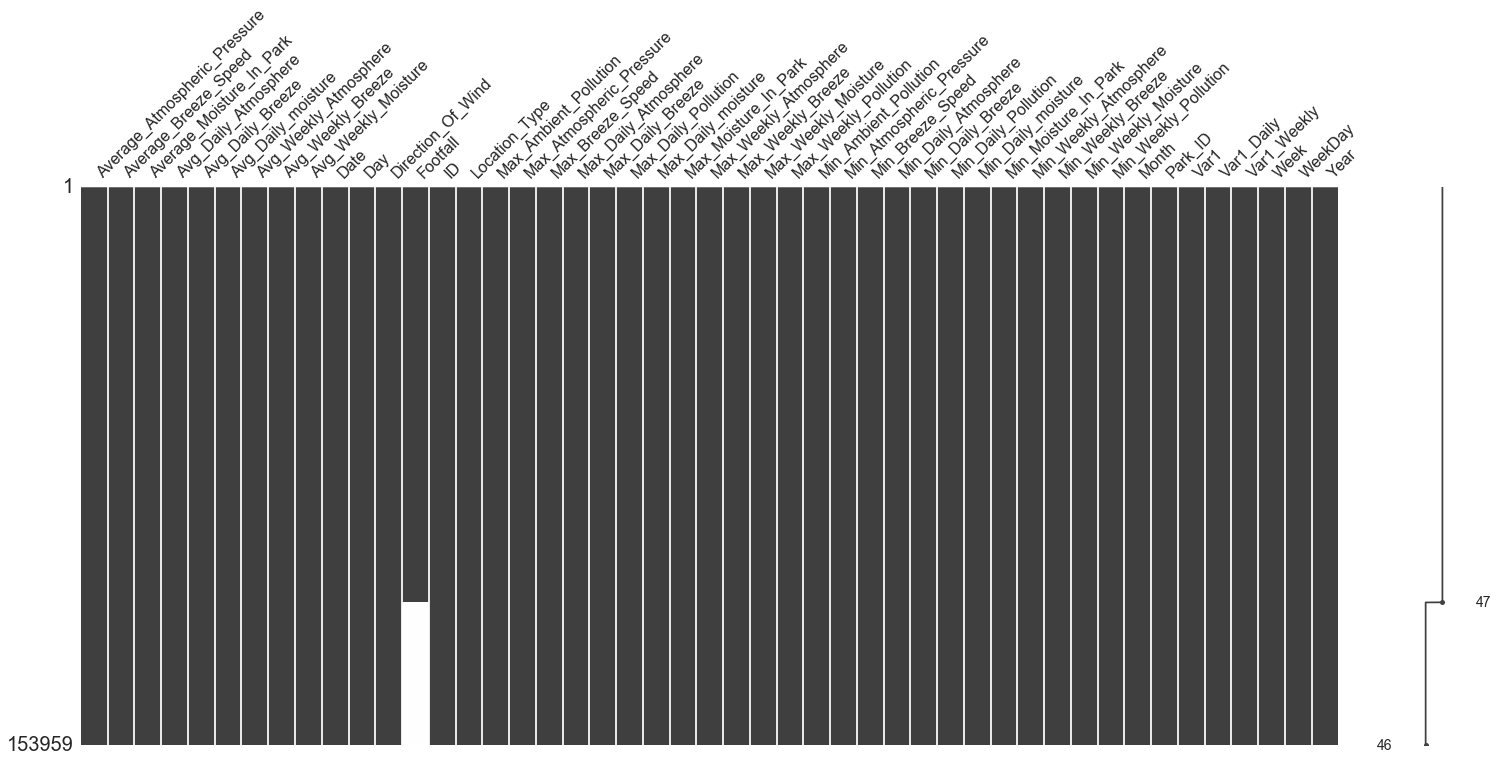

In [72]:
df_missing_check = df.append(df_test)
df_missing_check = df_missing_check.sort_values(['Date', 'Park_ID'], ascending=[1, 1])
msno.matrix(df_missing_check)

## Model Building

### Gradient Boosted Trees

- Max depth of 5 is most effective

- Outperformed both random forests and AdaBoost

In [73]:
X = df.drop(['ID', 'Footfall', 'Date', 'Year'
             , 'Location_Type', 'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure'
             , 'Var1', 'Max_Ambient_Pollution', 'Min_Atmospheric_Pressure'
             , 'Max_Breeze_Speed', 'Min_Breeze_Speed', 'Min_Ambient_Pollution'
             , 'Max_Moisture_In_Park'
            ], axis = 1)
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
X = imp.fit_transform(X)

y = df['Footfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [74]:
gbr = GradientBoostingRegressor(n_estimators = 300
                               , max_depth = 5
                               )
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [75]:
# Regular cross validation
np.mean(cross_val_score(gbr, X_test, y_test, n_jobs = 3))

0.95762687239052224

In [76]:
# K-fold cross validation

k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
cross_val_score(gbr, X, y, cv=k_fold, n_jobs=3)

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\skl

array([ 0.96254909,  0.96338802,  0.96328219,  0.96139247,  0.96212329,
        0.9647377 ,  0.96253464,  0.96374171,  0.96351884,  0.96228093])

Examining the distance of predictions from the actual, and looking for common characteristics among the parts with the biggest differences.

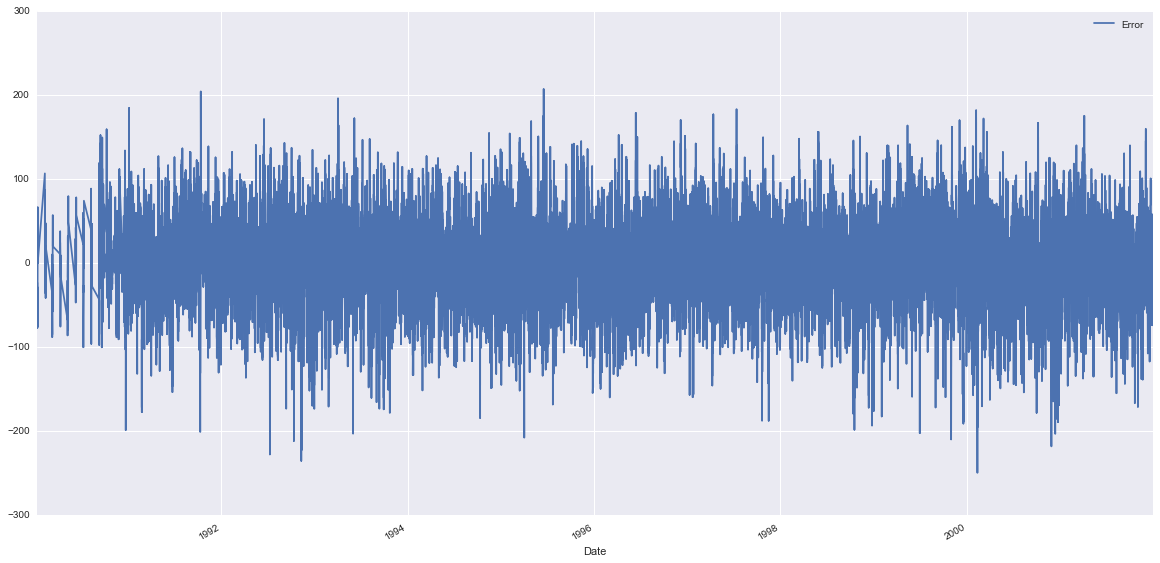

In [77]:
# Plot of error over time
y_pred = gbr.predict(X_test)

cv_error = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': (y_test - y_pred)})
cv_error = pd.merge(df, cv_error, left_index=True, right_index=True)

error_plot = cv_error[['Date', 'Error']]
error_plot = error_plot.set_index('Date')
error_plot.plot(figsize = (20,10))

In [78]:
cv_error.sort_values('Error').head()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,...,Max_Weekly_Atmosphere,Min_Weekly_Atmosphere,Max_Weekly_Pollution,Min_Weekly_Pollution,Avg_Weekly_Moisture,Max_Weekly_Moisture,Min_Weekly_Moisture,Actual,Error,Predicted
95947,3686224,24,2000-02-12,178.000000,16.720000,38.000000,0.000000,1.66,8300.000000,8317.000000,...,8339.769841,8302.928571,318.951724,153.875862,246.730159,284.904762,200.650794,528,-250.086489,778.086489
22191,3388817,17,1992-11-10,138.026667,78.072267,97.077333,58.773333,0.00,8005.033333,8043.626667,...,8285.809524,8245.206349,291.910448,153.671642,254.158163,278.739796,225.091837,1011,-235.739930,1246.739930
18749,3388419,19,1992-07-10,83.000000,31.160000,45.600000,15.200000,0.00,8341.000000,8355.000000,...,8341.722222,8287.119048,324.059701,160.686567,240.734694,281.693878,186.000000,1035,-228.127802,1263.127802
18751,3388421,21,1992-07-10,81.000000,27.360000,45.600000,15.200000,0.00,8348.000000,8358.000000,...,8341.722222,8287.119048,324.059701,160.686567,240.734694,281.693878,186.000000,999,-227.231848,1226.231848
22247,3394917,17,1992-11-12,138.166667,78.330667,97.330667,59.026667,0.00,8005.033333,8043.626667,...,8285.809524,8245.206349,291.910448,153.671642,254.158163,278.739796,225.091837,652,-222.944937,874.944937


In [79]:
cv_error.sort_values('Error').tail()

,ID,Park_ID,Date,Direction_Of_Wind,Average_Breeze_Speed,Max_Breeze_Speed,Min_Breeze_Speed,Var1,Average_Atmospheric_Pressure,Max_Atmospheric_Pressure,...,Max_Weekly_Atmosphere,Min_Weekly_Atmosphere,Max_Weekly_Pollution,Min_Weekly_Pollution,Avg_Weekly_Moisture,Max_Weekly_Moisture,Min_Weekly_Moisture,Actual,Error,Predicted
69981,3562439,39,1997-07-13,204.000000,25.080000,45.600000,0.000000,0.000000,8000.260000,8042.993333,...,8361.619048,8293.492063,315.517730,194.496454,250.790816,287.770408,208.040816,1703,182.894997,1520.105003
3429,3335939,39,1991-01-05,20.000000,36.480000,53.200000,22.800000,0.000000,8000.400000,8042.313333,...,8362.590278,8287.125000,299.838926,111.087248,265.745455,290.850000,225.940909,1323,184.154605,1138.845395
26230,3403224,24,1993-04-03,159.000000,26.600000,38.000000,15.200000,0.000000,8341.000000,8358.000000,...,8381.301587,8309.087302,303.657143,147.142857,252.214286,287.311224,201.443878,1230,195.827119,1034.172881
11167,3352417,17,1991-10-13,140.313333,78.072267,97.026667,59.077333,0.000000,8005.033333,8044.040000,...,8408.166667,8359.476190,309.082707,173.593985,252.872449,284.448980,204.811224,1536,203.969139,1332.030861
48807,3486833,33,1995-06-18,67.000000,21.280000,38.000000,0.000000,192.631933,8420.000000,8441.000000,...,8362.158730,8313.317460,317.285714,182.400000,232.301020,282.260204,176.326531,1663,206.940381,1456.059619


Viewing variable importance - used to discard unnecessary variables

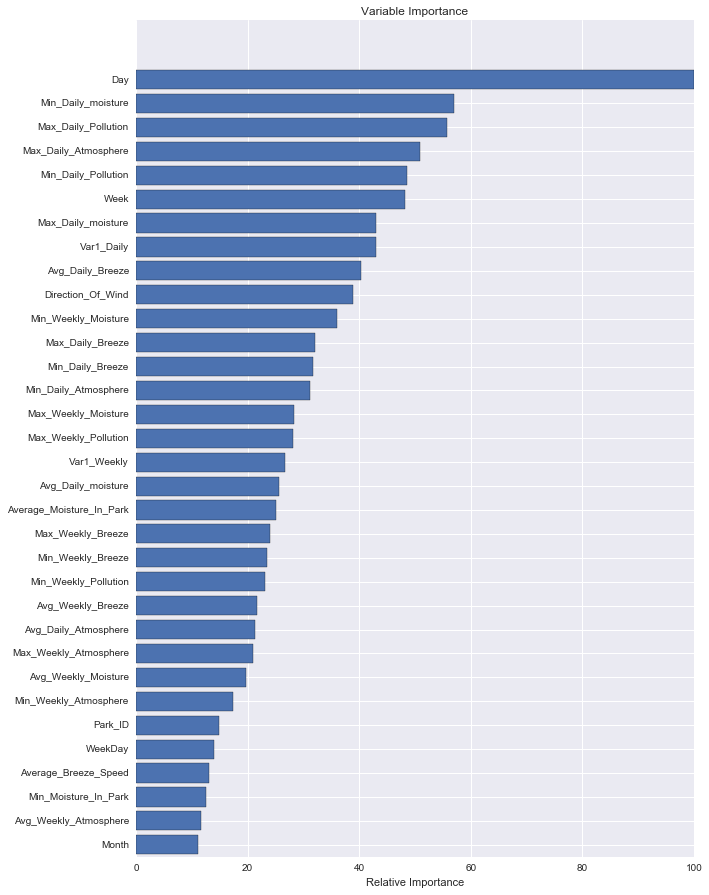

In [80]:
# Plotting feature importance

gbr_labels = df_test.drop(['ID', 'Date', 'Year'
             , 'Location_Type', 'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure'
             , 'Var1', 'Max_Ambient_Pollution', 'Min_Atmospheric_Pressure'
             , 'Max_Breeze_Speed', 'Min_Breeze_Speed', 'Min_Ambient_Pollution'
             , 'Max_Moisture_In_Park'
                            ], axis = 1)

feature_importance = gbr.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, gbr_labels.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Outputting Predictions

In [81]:
# Predicting for submission
X_submission = df_test.drop(['ID', 'Date', 'Year'
             , 'Location_Type', 'Average_Atmospheric_Pressure', 'Max_Atmospheric_Pressure'
             , 'Var1', 'Max_Ambient_Pollution', 'Min_Atmospheric_Pressure'
             , 'Max_Breeze_Speed', 'Min_Breeze_Speed', 'Min_Ambient_Pollution'
             , 'Max_Moisture_In_Park'
                            ], axis = 1)
X_submission = imp.fit_transform(X_submission)
y_submission = gbr.predict(X_submission)

In [82]:
# Exporting results
df_submission = pd.DataFrame(y_submission, index = df_test['ID'])
df_submission.columns = ['Footfall']
df_submission.to_csv('test.csv')

In [83]:
# Saving train/test with imputed null values
df.to_csv('train_imputed.csv')
df_test.to_csv('test_imputed.csv')